In [1]:
# imports
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import pathlib
import os
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors

C:\Users\kras\AppData\Local\Temp\ipykernel_17596\404450261.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [4]:
# opening STAC catalog, either a url, cloud storage link or a local (cloned) folder
cwd = pathlib.Path().resolve()

catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/dgds-data-public/gca/gca-stac/catalog.json" # cloud API
    #os.path.join(os.path.dirname(cwd), "stac_folder", "current", "catalog.json") # local clone 
)
#catalog

In [5]:
list(catalog.get_children())

[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=world_pop>,
 <CollectionClient id=world_gdp>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>]

In [6]:
href = catalog.get_child("esl_gwl").assets["data"].href

In [7]:
ds = xr.open_zarr(href)

In [8]:
ds

<xarray.Dataset>
Dimensions:   (ensemble: 3, rp: 5, gwl: 4, nstations: 230)
Coordinates:
  * ensemble  (ensemble) int64 5 50 95
  * gwl       (gwl) float64 0.0 1.5 3.0 5.0
    lat       (nstations) float64 dask.array<chunksize=(230,), meta=np.ndarray>
    lon       (nstations) float64 dask.array<chunksize=(230,), meta=np.ndarray>
  * rp        (rp) float64 5.0 10.0 20.0 50.0 100.0
    stations  (nstations) |S15 dask.array<chunksize=(230,), meta=np.ndarray>
Dimensions without coordinates: nstations
Data variables:
    esl       (rp, gwl, ensemble, nstations) float64 dask.array<chunksize=(5, 4, 3, 230), meta=np.ndarray>
Attributes: (12/21)
    AUTHOR:              Tebaldi, C., Ranasinghe, R., Vousdoukas, M., Rasmuss...
    CITATION:            Tebaldi, C., Ranasinghe, R., Vousdoukas, M., Rasmuss...
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         Extreme sea level projections for five return period...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['climate change', 'extreme sea level', 'deltas']
    TEMPORAL_EXTENT:     ['2100-01-01T00:00:00Z']
    TITLE:               ESL by GWL
    TITLE_ABBREVIATION:  esl_gwl
    UNITS:               m

In [9]:
# plot input params
area = "Bangladesh" # look at np.unique(ds.stations.values) for options
GWL = 0 # look at ds.gwl.values for options
#ens = 50 # look at ds.ensemble.values for options
rp = 50.0 # look at ds.rp.values for options

# world shapefile
shapefile = r'p:\11208003-latedeo2022\020_InternationalDeltaPortfolio\datasets\05_world-administrative-boundaries\world-administrative-boundaries.shp'
world = gpd.read_file(shapefile)

In [10]:
# cropping
loclist = [i.decode("utf-8") for i in ds.stations.values]
idx_locl = [idx for idx, i in enumerate(loclist) if i == area] # idx matching the area string
ds_fil = ds.isel(nstations=idx_locl) # filter the area string
ds_fil = ds_fil.sel(gwl = GWL, rp = rp) # filter the other params

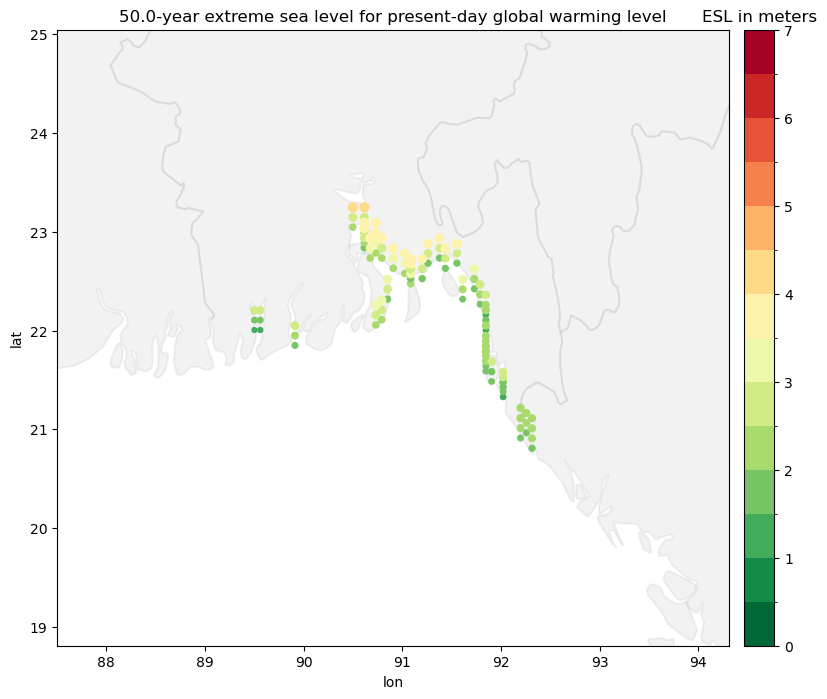

In [11]:
# plotting
cmap = mpl.cm.RdYlGn_r
norm = colors.BoundaryNorm(np.arange(0, 7.5, 0.5), cmap.N)
if GWL == 0:
    GWLs = 'present-day'
else:
    GWLs = '%s degree'%GWL

lonmin = min(ds_fil.lon.values); lonmax = max(ds_fil.lon.values);
latmin = min(ds_fil.lat.values); latmax = max(ds_fil.lat.values);
fig, ax = plt.subplots()
fig.set_size_inches(15, 8) #fig.set_size_inches(15, 20)
base = world.boundary.plot(ax=ax, edgecolor='grey',facecolor='grey',alpha=0.1,zorder=0);
im1 = ax.scatter(ds_fil.lon.values,ds_fil.lat.values,10*ds_fil.sel(ensemble=5).esl.values,ds_fil.sel(ensemble=5).esl.values,cmap=cmap, norm=norm,zorder=1)
# plt.set_clim(0,5)
im2 = ax.scatter(ds_fil.lon.values,ds_fil.lat.values+0.1,10*ds_fil.sel(ensemble=50).esl.values,ds_fil.sel(ensemble=50).esl.values,cmap=cmap, norm=norm,zorder=1)
im3 = ax.scatter(ds_fil.lon.values,ds_fil.lat.values+0.2,10*ds_fil.sel(ensemble=95).esl.values,ds_fil.sel(ensemble=95).esl.values,cmap=cmap, norm=norm,zorder=1)
ax.set_title('%s-year extreme sea level for %s global warming level'%(rp, GWLs))
ax.axis('square')
ax.set(xlabel = 'lon', ylabel = 'lat', xlim=[lonmin-2,lonmax+2], ylim=[latmin-2,latmax+2]);
#fig.colorbar(im1, ax=ax)
im1.set_clim(0,7)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height]) # to give colorbar own axes
plt.colorbar(im1, cax=cax) # Similar to fig.colorbar(im, cax = cax)
cax.set_title('ESL in meters');# 